In [ ]:
# Set up
import os
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sbn
import boto
import boto3
import io
import csv
import warnings
import numpy as np
%matplotlib inline
path = '/Users/sheri/documents/data science/data mining/homework/project 1'

os.listdir(path)

['.ipynb_checkpoints',
 'FaultCode_DowntimeMapping.xlsx',
 'LGW_Down_Turbine_Tracker.xlsx',
 'Lightning.csv',
 'Meteorological data writeup.docx',
 'Meteorological_Notebook_SAL.py',
 'MetTower (1).ipynb',
 'MetTower.ipynb',
 'MetTower_complete.csv',
 'MetTower_LGW_2017.csv',
 'PowerCurveData.csv',
 'PowerCurves.csv',
 'Siemens Error Code Stop and Reset Details.xlsx',
 'Siemens_Fault_Code_Descriptions.xlsx',
 'tblSCTurbine.csv',
 'WpsHistoryDescription_V_310.pdf',
 '~$teorological data writeup.docx']

# Meteorological Conditions versus Turbine Performance

I wanted to look at the meteorological data to see how much that could help explain turbine performance. The factors I looked at were Barometric Pressure, Humidity, and Air Temperature (measured at 3meters and at 76 meters to see if a temperature differential makes a difference).

In [2]:
#reading in meteorlogical data for 2017
df_m = pd.read_csv(path + '/MetTower_LGW_2017.csv')
df_m.head()
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 22 columns):
TmStamp                    52560 non-null object
RecNum                     52560 non-null int64
WS_P2546a_80m_Avg          52560 non-null float64
WS_Thies_80m_Avg           52560 non-null float64
Windsp_3D_Avg              52560 non-null float64
WindDir_Angle_3D_Avg       52560 non-null float64
Elevation_angle_3D_Avg     52560 non-null float64
Temp_3D_Avg                52560 non-null float64
WindDir_76m_D1_WVT         52560 non-null float64
WindDir_76m_SD1_WVT        52560 non-null float64
WindDir_ICEFREE_D1_WVT     52560 non-null float64
WindDir_ICEFREE_SD1_WVT    52560 non-null float64
WS_ICEFREE_Avg             52560 non-null float64
AirTC_76m_Avg              52555 non-null float64
RH_76m_Avg                 52560 non-null float64
BP_mbar_76m_Avg            52560 non-null float64
WS_Thies_60m_Avg           52560 non-null float64
WS_Thies_26m_Avg           52560 non-null fl

In [3]:
#reading in turbine performance data
df_p = pd.read_csv(path + '/tblSCTurbine.csv')

df_p.head()




,Name,TimeStamp,wtc_CurTime_endvalue,wtc_SecAnemo_mean,wtc_YawPos_mean,wtc_GenRpm_mean,wtc_HubLubGr_mean,wtc_IceDetec_mean,wtc_IMidBa_mean,wtc_IMidCa_mean,...,wtc_ReactRef_endvalue,wtc_ScYawPos_mean,wtc_PrWindSp_mean,wtc_SeWindSp_mean,wtc_AcWindSp_mean,wtc_NacelPos_mean,wtc_TetAnemo_mean,wtc_TetAnFrq_mean,wtc_TowerFrq_Frequenc_mean,wtc_BoostAva_mean
0,T010,2015-05-19 23:00:00.000,2015-05-19 22:59:56.000,8.026840,40.70000,0.6,NaN,NaN,NaN,NaN,...,NaN,40.70000,9.485412,8.017353,9.485392,40.70000,NaN,0.01,0.2004,0.0
1,T010,2015-05-19 23:10:00.000,2015-05-19 23:09:56.000,8.709124,12.69578,0.6,NaN,NaN,NaN,NaN,...,NaN,10.96358,8.437153,8.697805,8.437179,12.70296,NaN,0.01,0.2004,0.0
2,T010,2015-05-19 23:20:00.000,2015-05-19 23:19:56.000,10.432920,311.68360,0.6,NaN,NaN,NaN,NaN,...,NaN,68.03295,10.836880,10.431380,10.836890,311.68570,NaN,0.01,0.2004,0.0
3,T010,2015-05-19 23:30:00.000,2015-05-19 23:29:56.000,8.176679,164.15750,0.6,NaN,NaN,NaN,NaN,...,NaN,-194.58410,9.402458,8.174048,9.402458,164.16360,NaN,0.01,0.2004,0.0
4,T010,2015-05-19 23:40:00.000,2015-05-19 23:39:56.000,8.793220,151.80000,0.6,NaN,NaN,NaN,NaN,...,NaN,-208.20000,9.098410,8.795180,9.098390,151.80000,NaN,0.01,0.2004,0.0


In [4]:

#selecting columns of interest from the meteorological data set 
df_m = df_m[['TmStamp', 'RH_76m_Avg', 'BP_mbar_76m_Avg', 'AirTC_3m_Avg','AirTC_76m_Avg']]
df_m.describe()

# Need to convert TimeStamp from object to datetime
df_m['TmStamp'] = pd.to_datetime(df_m['TmStamp'])
df_m.info()

# setting the index by Timestamp adds plotting functionality and drops the column.
df_m.set_index('TmStamp', inplace=True)
df_m.index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 6 columns):
TmStamp            52560 non-null datetime64[ns]
Temp_3D_Avg        52560 non-null float64
RH_76m_Avg         52560 non-null float64
BP_mbar_76m_Avg    52560 non-null float64
AirTC_3m_Avg       52560 non-null float64
AirTC_76m_Avg      52555 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 2.4 MB


DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 00:10:00',
               '2017-01-01 00:20:00', '2017-01-01 00:30:00',
               '2017-01-01 00:40:00', '2017-01-01 00:50:00',
               '2017-01-01 01:00:00', '2017-01-01 01:10:00',
               '2017-01-01 01:20:00', '2017-01-01 01:30:00',
               ...
               '2017-12-31 22:20:00', '2017-12-31 22:30:00',
               '2017-12-31 22:40:00', '2017-12-31 22:50:00',
               '2017-12-31 23:00:00', '2017-12-31 23:10:00',
               '2017-12-31 23:20:00', '2017-12-31 23:30:00',
               '2017-12-31 23:40:00', '2017-12-31 23:50:00'],
              dtype='datetime64[ns]', name='TmStamp', length=52560, freq=None)

# Turbine Performance Measure

I used the Mean RPM of the turbine to measure the performance of the turbine. I then compared the meteorological factors with my measure of Turbine performance.

In [7]:

#selecting columns of interest from the turbine performance data set
df_p = df_p[['TimeStamp', 'wtc_GenRpm_mean', 'wtc_AcWindSp_mean']]
# Need to convert TimeStamp from object to datetime
df_p['TimeStamp'] = pd.to_datetime(df_p['TimeStamp'])
df_p.info()


# setting the index by Timestamp adds plotting functionality and drops the column.
df_p.set_index('TimeStamp', inplace=True)
# choosing only the 2017 data 
df_p = df_p['2017-01-01':'2017-12-31']
df_p.index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12742244 entries, 0 to 12742243
Data columns (total 3 columns):
TimeStamp            datetime64[ns]
wtc_GenRpm_mean      float64
wtc_AcWindSp_mean    float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 291.6 MB


DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 00:00:00',
               '2017-01-01 00:00:00', '2017-01-01 00:00:00',
               '2017-01-01 00:00:00', '2017-01-01 00:00:00',
               '2017-01-01 00:00:00', '2017-01-01 00:00:00',
               '2017-01-01 00:00:00', '2017-01-01 00:00:00',
               ...
               '2017-12-31 23:50:00', '2017-12-31 23:50:00',
               '2017-12-31 23:50:00', '2017-12-31 23:50:00',
               '2017-12-31 23:50:00', '2017-12-31 23:50:00',
               '2017-12-31 23:50:00', '2017-12-31 23:50:00',
               '2017-12-31 23:50:00', '2017-12-31 23:50:00'],
              dtype='datetime64[ns]', name='TimeStamp', length=4544868, freq=None)

In [8]:
#Merging the meteorlogical and performance data
df = df_m.merge(df_p,left_index=True,right_index=True)
df.head()

,Temp_3D_Avg,RH_76m_Avg,BP_mbar_76m_Avg,AirTC_3m_Avg,AirTC_76m_Avg,wtc_GenRpm_mean,wtc_AcWindSp_mean
2017-01-01,225.7,75.79,945.0,8.67,9.14,1270.048,8.741180
2017-01-01,225.7,75.79,945.0,8.67,9.14,1200.634,8.344568
2017-01-01,225.7,75.79,945.0,8.67,9.14,1436.309,11.170890
2017-01-01,225.7,75.79,945.0,8.67,9.14,1396.525,10.997920
2017-01-01,225.7,75.79,945.0,8.67,9.14,1437.861,11.212080


# Histograms and Box Plots

I plotted histograms and boxplots on the various factors to get a better idea of how each factor varied over time.
In the histograms we can see that the temperature at three meters height is more variable than the temperature at 76 meters. The barometric pressure is very stable while the humidity varies quite a bit.
The mean rpm of the turbine varies but is clearly at maximum more of the time than at lower output levels. This variation should help show how much the meteorological factors affect the RPM.  


Using box plots we can see each factor in more detail. The variation within the three meter measure of temperature is clearly more variable than the 76 meter measure but there are more outliers within the 76 meter measure.
The barometric pressure shows the same stability although a couple of storms clearly happened and are shown as outliers.
While the humidity has a wide variation, the values are very consistent (few outliers) and are as expected in the Dallas, Texas region.


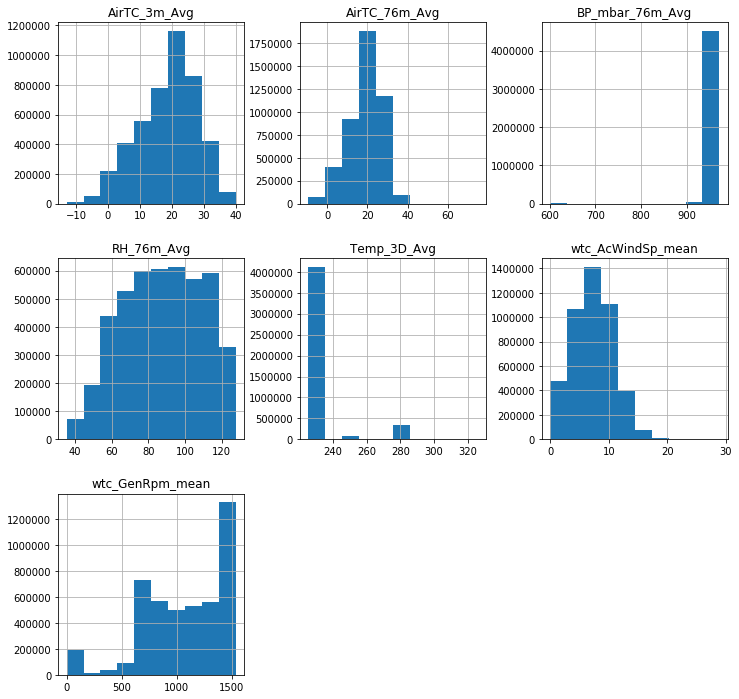

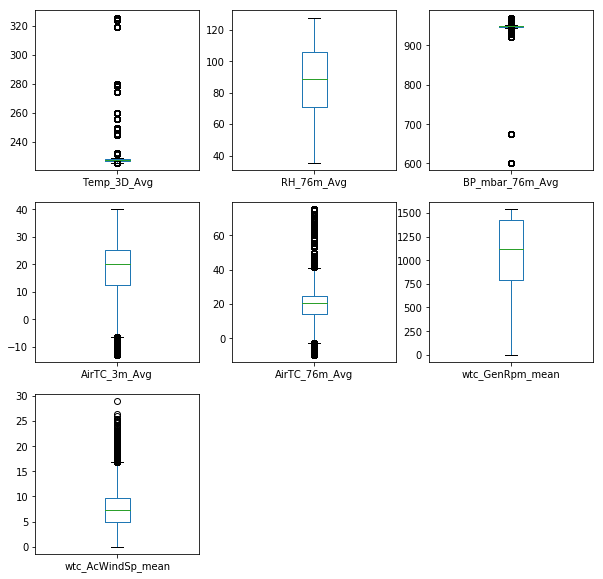

In [12]:
#Plots of interesting factors. 
#Code From: https://machinelearningmastery.com/visualize-machine-learning-data-python-pandas/
df.hist(figsize=(12,12))
plt.show()

df.plot(kind='box', subplots=True, layout=(3,3), figsize=(10,10), sharex=False, sharey=False)
plt.show()

# Correlation Plot

From this correlation plot we can see that wind speed is clearly the most predictive factor on turbine rpm. This is expected, but there is a slight negative correlation for rpm vs the other factors. Barometric pressure seems to have the most negative correlation while air temperature and humidity have about an approximately equal small negative effect.

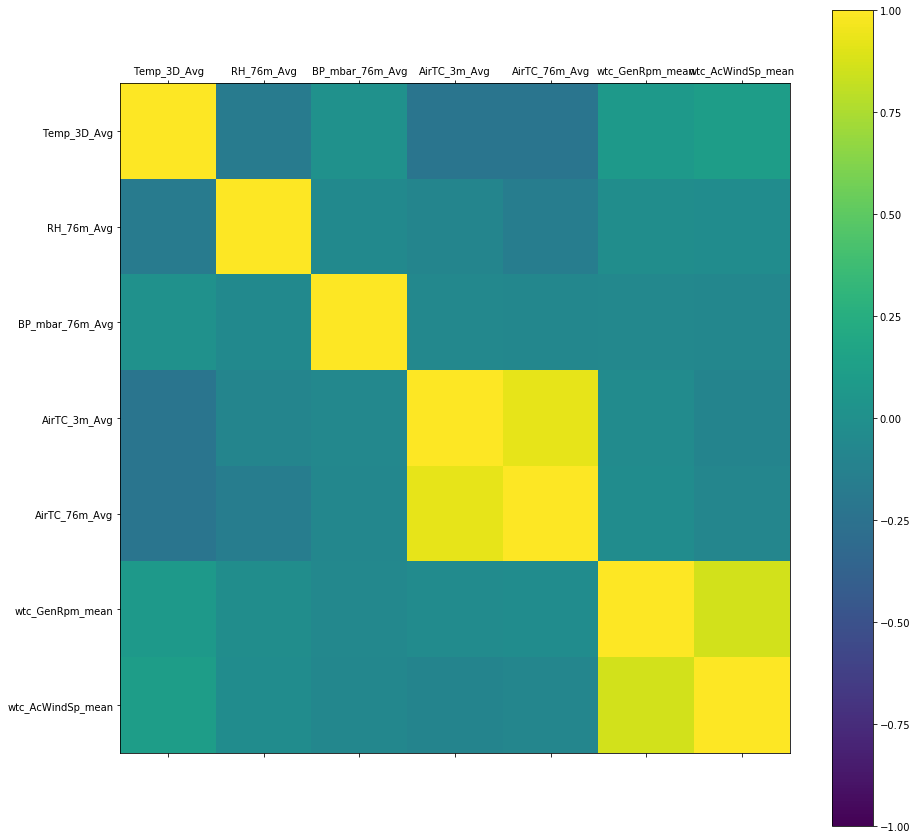

In [19]:
names = ['RH_76m_Avg', 'BP_mbar_76m_Avg', 'AirTC_3m_Avg','AirTC_76m_Avg','wtc_GenRpm_mean','wtc_AcWindSp_mean']
correlations = df.corr()
# plot correlation matrix
fig = plt.figure(figsize=(17,17))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,7,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

In [ ]:
#scatter plots
#scatter_matrix(df, figsize=(15,15))
#plt.show()